In [1]:
import os
import json
import numpy as np
import pandas as pd

import re
import string
import spacy
# Tải mô hình ngôn ngữ tiếng Anh từ spaCy
nlp = spacy.load("en_core_web_lg")

from sklearn.model_selection import train_test_split

import tensorflow as tf
from tensorflow import keras
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.layers import LSTM, Dense, Input, Embedding, Concatenate, TimeDistributed, Bidirectional, GRU
from tensorflow.keras.models import Model
from tensorflow.keras.callbacks import EarlyStopping
from keras.utils.vis_utils import plot_model

# Đọc data

In [2]:
df = pd.read_csv("/kaggle/input/data22/data.csv")
df

,article,highlights
0,by bianca london she be no stranger to be hand...,<sostok> coronation street star top poll with ...
1,by james slack home affairs editor published 1...,<sostok> new proposal will mean deportee can o...
2,by lizzie parry john and corinne clarkson have...,<sostok> john and corinne clarkson cook up the...
3,december 19 2014 cnn student news be wrap up 2...,<sostok> this page include the show transcript...
4,by associated press published 14:11 est 25 oct...,<sostok> bishop john folda of north dakota be ...
...,...,...
99995,cnn i learn that courage be not the absence o...,<sostok> kevin prince boateng s walk off prote...
99996,by daily mail reporter published 09:33 est 18 ...,<sostok> the teacher at hyatt elementary schoo...
99997,spur still so far from the top four it be the ...,<sostok> tottenham be thrash by manchester cit...
99998,by daily mail reporter published 13:19 est 2 m...,<sostok> speedway coach michael green 71 jail ...


In [3]:
train_data = df.iloc[:99000,:]
test_data = df.iloc[99000:,:]

In [4]:
train_data

,article,highlights
0,by bianca london she be no stranger to be hand...,<sostok> coronation street star top poll with ...
1,by james slack home affairs editor published 1...,<sostok> new proposal will mean deportee can o...
2,by lizzie parry john and corinne clarkson have...,<sostok> john and corinne clarkson cook up the...
3,december 19 2014 cnn student news be wrap up 2...,<sostok> this page include the show transcript...
4,by associated press published 14:11 est 25 oct...,<sostok> bishop john folda of north dakota be ...
...,...,...
98995,by mario ledwith published 06:50 est 4 march 2...,<sostok> lisa foster 31 steal almost 8000 from...
98996,over the year americans have become familiar w...,<sostok> ruben navarrette there be a new term ...
98997,jack wilshere look upbeat despite his ankle op...,<sostok> jack wilshere have not play for arsen...
98998,daniel schofield ply schoolgirl with alcohol b...,<sostok> daniel schofield 26 be describe as im...


# Xác định khoảng tập trung độ dài của dữ liệu

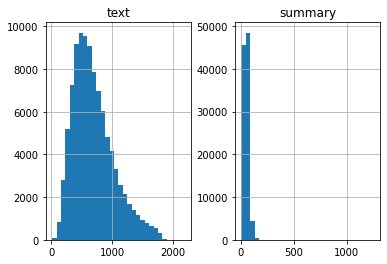

In [5]:
import matplotlib.pyplot as plt
text_word_count = []
summary_word_count = []

# populate the lists with sentence lengths
for i in train_data['article']:
      text_word_count.append(len(i.split()))

for i in train_data['highlights']:
      summary_word_count.append(len(i.split()))

length_df = pd.DataFrame({'text':text_word_count, 'summary':summary_word_count})
length_df.hist(bins = 30)
plt.show()

In [6]:
maxlen_text = 800
maxlen_summ = 150

# Tokenizing Text And Summary Data

In [7]:
train_x, val_x, train_y, val_y = train_test_split(train_data['article'], train_data['highlights'], test_size=0.1, random_state=42)

In [8]:
t_tokenizer = Tokenizer()
t_tokenizer.fit_on_texts(list(train_x))

thresh = 4
count = 0
total_count = 0
frequency = 0
total_frequency = 0
# đếm tần suất 
for key, value in t_tokenizer.word_counts.items():
    total_count += 1
    total_frequency += value
    if value < thresh:
        count += 1
        frequency += value

In [9]:
print('% các từ ít xuất hiện: ', (count/total_count)*100.0)
print('% Tần xuất từ ít xuất hiện: ', (frequency/total_frequency)*100.0)
t_max_features = total_count - count
print('Số từ sau khi loại bỏ từ ít xuất hiện: ', t_max_features)

% các từ ít xuất hiện:  59.79990006623517
% Tần xuất từ ít xuất hiện:  0.36505148947641547
Số từ sau khi loại bỏ từ ít xuất hiện:  103785


In [10]:
s_tokenizer = Tokenizer()
s_tokenizer.fit_on_texts(list(train_y))

thresh = 6
count = 0
total_count = 0
frequency = 0
total_frequency = 0

for key, value in s_tokenizer.word_counts.items():
    total_count += 1
    total_frequency += value
    if value < thresh:
        count += 1
        frequency += value

In [11]:
print('% các từ ít xuất hiện: ', (count/total_count)*100.0)
print('% Tần xuất từ ít xuất hiện: ', (frequency/total_frequency)*100.0)
s_max_features = total_count - count
print('Số từ sau khi loại bỏ từ ít xuất hiện: ', s_max_features)

% các từ ít xuất hiện:  75.91185489319682
% Tần xuất từ ít xuất hiện:  2.6382075835997236
Số từ sau khi loại bỏ từ ít xuất hiện:  23174


In [12]:
t_tokenizer = Tokenizer(num_words=t_max_features)
t_tokenizer.fit_on_texts(list(train_x))
train_x = t_tokenizer.texts_to_sequences(train_x)
val_x = t_tokenizer.texts_to_sequences(val_x)

train_x = pad_sequences(train_x, maxlen=maxlen_text, padding='post')
val_x = pad_sequences(val_x, maxlen=maxlen_text, padding='post')

In [13]:
s_tokenizer = Tokenizer(num_words=s_max_features)
s_tokenizer.fit_on_texts(list(train_y))
train_y = s_tokenizer.texts_to_sequences(train_y)
val_y = s_tokenizer.texts_to_sequences(val_y)

train_y = pad_sequences(train_y, maxlen=maxlen_summ, padding='post')
val_y = pad_sequences(val_y, maxlen=maxlen_summ, padding='post')

In [14]:
print("Training Sequence", train_x.shape)
print('Target Values Shape', train_y.shape)
print('Test Sequence', val_x.shape)
print('Target Test Shape', val_y.shape)

Training Sequence (89100, 800)
Target Values Shape (89100, 150)
Test Sequence (9900, 800)
Target Test Shape (9900, 150)


In [15]:
train_x

array([[  23,  488, 7035, ...,    0,    0,    0],
       [   4,  359, 3247, ...,    0,    0,    0],
       [  23,  675, 1344, ...,    0,    0,    0],
       ...,
       [1135,   26,   37, ..., 1255,  119, 4698],
       [ 122, 1119, 1140, ...,    0,    0,    0],
       [ 123, 3496,  286, ...,    0,    0,    0]], dtype=int32)

# Pretrained Embedding

In [ ]:
embeding_index = {}
embed_dim = 200
with open('/kaggle/input/glove6b/glove.6B.200d.txt') as f:
    for line in f:
        values = line.split()
        word = values[0]
        coefs = np.asarray(values[1:], dtype='float32')
        embeding_index[word] = coefs

In [ ]:
t_embed = np.zeros((t_max_features, embed_dim))
for word, i in t_tokenizer.word_index.items():
    vec = embeding_index.get(word)
    if i < t_max_features and vec is not None:
        t_embed[i] = vec

In [ ]:
s_embed = np.zeros((s_max_features, embed_dim))
for word, i in s_tokenizer.word_index.items():
    vec = embeding_index.get(word)
    if i < s_max_features and vec is not None:
        s_embed[i] = vec

In [ ]:
del embeding_index

# Model

In [ ]:
latent_dim = 128
# Encoder
enc_input = Input(shape=(maxlen_text, ))
enc_embed = Embedding(t_max_features, embed_dim, input_length=maxlen_text, weights=[t_embed], trainable=False)(enc_input)
# h_lstm = LSTM(latent_dim, return_sequences=True, return_state=True)
# h_out, _, _ = h_lstm(enc_embed)
enc_lstm = Bidirectional(LSTM(latent_dim, return_state=True))
enc_output, enc_fh, enc_fc, enc_bh, enc_bc = enc_lstm(enc_embed)
enc_h = Concatenate(axis=-1, name='enc_h')([enc_fh, enc_bh])
enc_c = Concatenate(axis=-1, name='enc_c')([enc_fc, enc_bc])
#Decoder
dec_input = Input(shape=(None, ))
dec_embed = Embedding(s_max_features, embed_dim, weights=[s_embed], trainable=False)(dec_input)
dec_lstm = LSTM(latent_dim*2, return_sequences=True, return_state=True, recurrent_dropout=0.1)
dec_outputs, _, _ = dec_lstm(dec_embed, initial_state=[enc_h, enc_c])

dec_dense = TimeDistributed(Dense(s_max_features, activation='softmax'))
dec_output = dec_dense(dec_outputs)

model = Model([enc_input, dec_input], dec_output)
model.summary()

plot_model(
    model,
    to_file='./seq2seq_encoder_decoder.png',
    show_shapes=True,
    show_layer_names=True,
    rankdir='TB',
    expand_nested=False,
    dpi=96)

# **Train lần 1 để có best_model.h5**

In [ ]:
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint

In [ ]:
# Compile mô hình
model.compile(loss='sparse_categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

# Tạo callback cho early stopping
early_stop = EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience=2)

# Tạo callback cho model checkpoint
checkpoint = ModelCheckpoint('./best_model.h5', monitor='val_loss', mode='min', save_best_only=True, verbose=1)


In [ ]:
his = model.fit([train_x, train_y[:, :-1]], train_y.reshape(train_y.shape[0], train_y.shape[1], 1)[:, 1:], epochs= 2, callbacks=[early_stop, checkpoint], batch_size=64, verbose=1, validation_data=([val_x, val_y[:, :-1]], val_y.reshape(val_y.shape[0], val_y.shape[1], 1)[:, 1:]))

In [ ]:
model.save("./best_model.h5")

## Train tiếp mô hình best_model khi đã lưu mô hình

In [ ]:
# Tạo callback cho early stopping
early_stop = EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience=2)

# Tạo callback cho model checkpoint
checkpoint = ModelCheckpoint('./best_model1.h5', monitor='val_loss', mode='min', save_best_only=True, verbose=1)

In [ ]:
from keras.models import load_model
model_path = "/kaggle/input/model2/best_model.h5"

model1 = load_model(model_path)

In [ ]:
his = model1.fit([train_x, train_y[:, :-1]], train_y.reshape(train_y.shape[0], train_y.shape[1], 1)[:, 1:], epochs= 2, callbacks=[early_stop, checkpoint], batch_size=64, verbose=1, validation_data=([val_x, val_y[:, :-1]], val_y.reshape(val_y.shape[0], val_y.shape[1], 1)[:, 1:]))

In [ ]:
import matplotlib.pyplot as plt

plt.plot(his.history['loss'], label='train')
plt.plot(his.history['val_loss'], label='test')
plt.legend()
plt.show()

In [ ]:
enc_model = Model(inputs=enc_input, outputs=[enc_h, enc_c])

dec_init_state_h = Input(shape=(latent_dim*2, ))
dec_init_state_c = Input(shape=(latent_dim*2, ))

dec_out, dec_h, dec_c = dec_lstm(dec_embed, initial_state=[dec_init_state_h, dec_init_state_c])
dec_final = dec_dense(dec_out)

dec_model = Model([dec_input]+[dec_init_state_h, dec_init_state_c], [dec_final]+[dec_h, dec_c])

In [ ]:
import pickle

# Save encoder model
enc_model.save('./encoder_model.h5')

# Save decoder model
dec_model.save('./decoder_model.h5')

# Save tokenizer
with open('./s_tokenizer.pkl', 'wb') as f:
    pickle.dump(s_tokenizer, f)


In [ ]:
def generate_summary(input_seq):
    h, c = enc_model.predict(input_seq)
    
    next_token = np.zeros((1, 1))
    next_token[0, 0] = s_tokenizer.word_index['sostok']
    output_seq = ''
    
    stop = False
    count = 0
    
    while not stop:
        if count > 100:
            break
        decoder_out, state_h, state_c = dec_model.predict([next_token]+[h, c])
        token_idx = np.argmax(decoder_out[0, -1, :])
        
        if token_idx == s_tokenizer.word_index['eostok']:
            stop = True
        elif token_idx > 0 and token_idx != s_tokenizer.word_index['sostok']:
            token = s_tokenizer.index_word[token_idx]
            output_seq = output_seq + ' ' + token
        
        next_token = np.zeros((1, 1))
        next_token[0, 0] = token_idx
        h, c = state_h, state_c
        count += 1
        
    return output_seq

In [ ]:
test_inputs = t_tokenizer.texts_to_sequences(list(test_data.article))
test_inputs = pad_sequences(test_inputs, maxlen=maxlen_text, padding='post')

In [ ]:
test_data.reset_index(drop=True, inplace=True)
test_data.head()

# In một số kết quả của mô hình

In [ ]:
import csv
h = []
with open('./result.csv', 'w') as f:
    writer = csv.writer(f)
    writer.writerow(['Article', 'Original Summary', 'Model Output'])
    for i in range(100):
        our_summ = generate_summary(test_inputs[i].reshape(1, maxlen_text))
        h.append(our_summ)
        writer.writerow([test_data.article[i], test_data.highlights[i], our_summ])

---

In [ ]:
import tensorflow as tf
import numpy as np
import pickle

def generate2_summary2(input_text):
    # Load the tokenizer
    with open('./s_tokenizer.pkl', 'rb') as f:
        s_tokenizer = pickle.load(f)
    
    # Load the model
    enc_model = tf.keras.models.load_model('./encoder_model.h5')
    dec_model = tf.keras.models.load_model('./decoder_model.h5')
    
    # Tokenize the input text
    input_seq = s_tokenizer.texts_to_sequences([input_text])
    input_seq = tf.keras.preprocessing.sequence.pad_sequences(input_seq, maxlen=800, padding='post')
    
    # Generate the summary
    h, c = enc_model.predict(input_seq)
    
    next_token = np.zeros((1, 1))
    next_token[0, 0] = s_tokenizer.word_index['sostok']
    output_seq = ''
    
    stop = False
    count = 0
    
    while not stop:
        if count > 100:
            break
        decoder_out, state_h, state_c = dec_model.predict([next_token]+[h, c])
        token_idx = np.argmax(decoder_out[0, -1, :])
        
        if token_idx == s_tokenizer.word_index['eostok']:
            stop = True
        elif token_idx > 0 and token_idx != s_tokenizer.word_index['sostok']:
            token = s_tokenizer.index_word[token_idx]
            output_seq = output_seq + ' ' + token
        
        next_token = np.zeros((1, 1))
        next_token[0, 0] = token_idx
        h, c = state_h, state_c
        count += 1
        
    return output_seq.strip()

In [ ]:
text = '''
Manchester City youngster Albert Rusnak is at the centre of a three-way transfer battle ahead of next month's transfer window. PAOK, Heerenveen and Groningen are all interested in signing the talented Slovakian in January and have contacted City about potential moves. Rusnak is set to bid a fond farewell to the Etihad Stadium on a permanent basis next month. Albert Rusnak (on loan at SC Cambuur) is at the centre of a three-way transfer battle ahead of next month. The Slovakian is highly thought of but Manchester Citys big spending meant he couldnt break into the team. The 20-year-old is currently on loan with Dutch club SC Cambuur, where he has impressed scoring four goals in 16 appearances, which has led to him being described as the Pearl of the Eredivisie by Dutch press.
And his displays have caught the attention of a number of clubs across Europe. Having joined City as a 16-year-old, Rusnak has strong emotional ties with the Etihad Stadium club. But the attacking midfielder wants to continue his football education elsewhere. His current loan deal expires on January 1, but City are open to allowing the youngster to leave on a permanent deal in January. Rusnak is highly-rated by City coaches following his arrival from FC Kosice as a teenage prodigy. But the club's big spending era ultimately meant the talented Slovakian could not break into the senior set-up. And Rusnak is optimistic a permanent switch away next month can catapult him into the senior Slovakia set-up.", highlights: Manchester Citys Albert Rusnak set to leave the club next month .The 20-year-old is currently on loan at Dutch club SC Cambuur .The attacking midfielder has drawn interest from several clubs
'''

generate2_summary2(text)